In [34]:
# 1. IMPORT REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')




In [35]:
# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [36]:
df = pd.read_csv('../data/csv/common_player_info.csv')



print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (4171, 33)

First few rows:
   person_id first_name     last_name   display_first_last  \
0      76001       Alaa     Abdelnaby       Alaa Abdelnaby   
1      76003     Kareem  Abdul-Jabbar  Kareem Abdul-Jabbar   
2       1505      Tariq   Abdul-Wahad    Tariq Abdul-Wahad   
3        949    Shareef   Abdur-Rahim  Shareef Abdur-Rahim   
4      76005        Tom     Abernethy        Tom Abernethy   

  display_last_comma_first  display_fi_last          player_slug  \
0          Abdelnaby, Alaa     A. Abdelnaby       alaa-abdelnaby   
1     Abdul-Jabbar, Kareem  K. Abdul-Jabbar  kareem-abdul-jabbar   
2       Abdul-Wahad, Tariq   T. Abdul-Wahad    tariq-abdul-wahad   
3     Abdur-Rahim, Shareef   S. Abdur-Rahim  shareef-abdur-rahim   
4           Abernethy, Tom     T. Abernethy        tom-abernethy   

          birthdate          school country  ...                   playercode  \
0  24/06/1968 00:00            Duke     USA  ...       HISTADD_alaa_abdelnaby   
1  16/04/1947

In [37]:
# 3. DATA CLEANING 

print("\n=== DATA CLEANING ===")


# Check for missing values 
print('Missing values per column: ')
print(df.isnull().sum())

#Convert Birthdate to Datetime and calculate age 

df['birthdate'] = pd.to_datetime(df['birthdate'])
df['age'] = (pd.to_datetime('2023-12-31') - df['birthdate']).dt.days / 365.25

# Create career length feature
df['career_length'] = df['to_year'] - df['from_year']

# Handle draft information
df['draft_year'] = pd.to_numeric(df['draft_year'], errors='coerce')
df['draft_round'] = pd.to_numeric(df['draft_round'], errors='coerce')
df['draft_number'] = pd.to_numeric(df['draft_number'], errors='coerce')

print(f"Processed {len(df)} players")



=== DATA CLEANING ===
Missing values per column: 
person_id                             0
first_name                            0
last_name                             0
display_first_last                    0
display_last_comma_first              0
display_fi_last                       0
player_slug                           0
birthdate                             0
school                               15
country                               1
last_affiliation                      0
height                               96
weight                              100
season_exp                            0
jersey                              980
position                             63
rosterstatus                          0
games_played_current_season_flag      0
team_id                               0
team_name                           702
team_abbreviation                   702
team_code                           702
team_city                           702
playercode                   


=== EXPLORATORY DATA ANALYSIS ===

Basic Statistics:
            weight   season_exp  career_length
count  4071.000000  4171.000000    4156.000000
mean    211.133382     5.195157       4.443455
std      26.926082     4.470879       4.633518
min     133.000000     0.000000       0.000000
25%     190.000000     2.000000       0.000000
50%     210.000000     3.000000       3.000000
75%     230.000000     8.000000       8.000000
max     360.000000    22.000000      55.000000


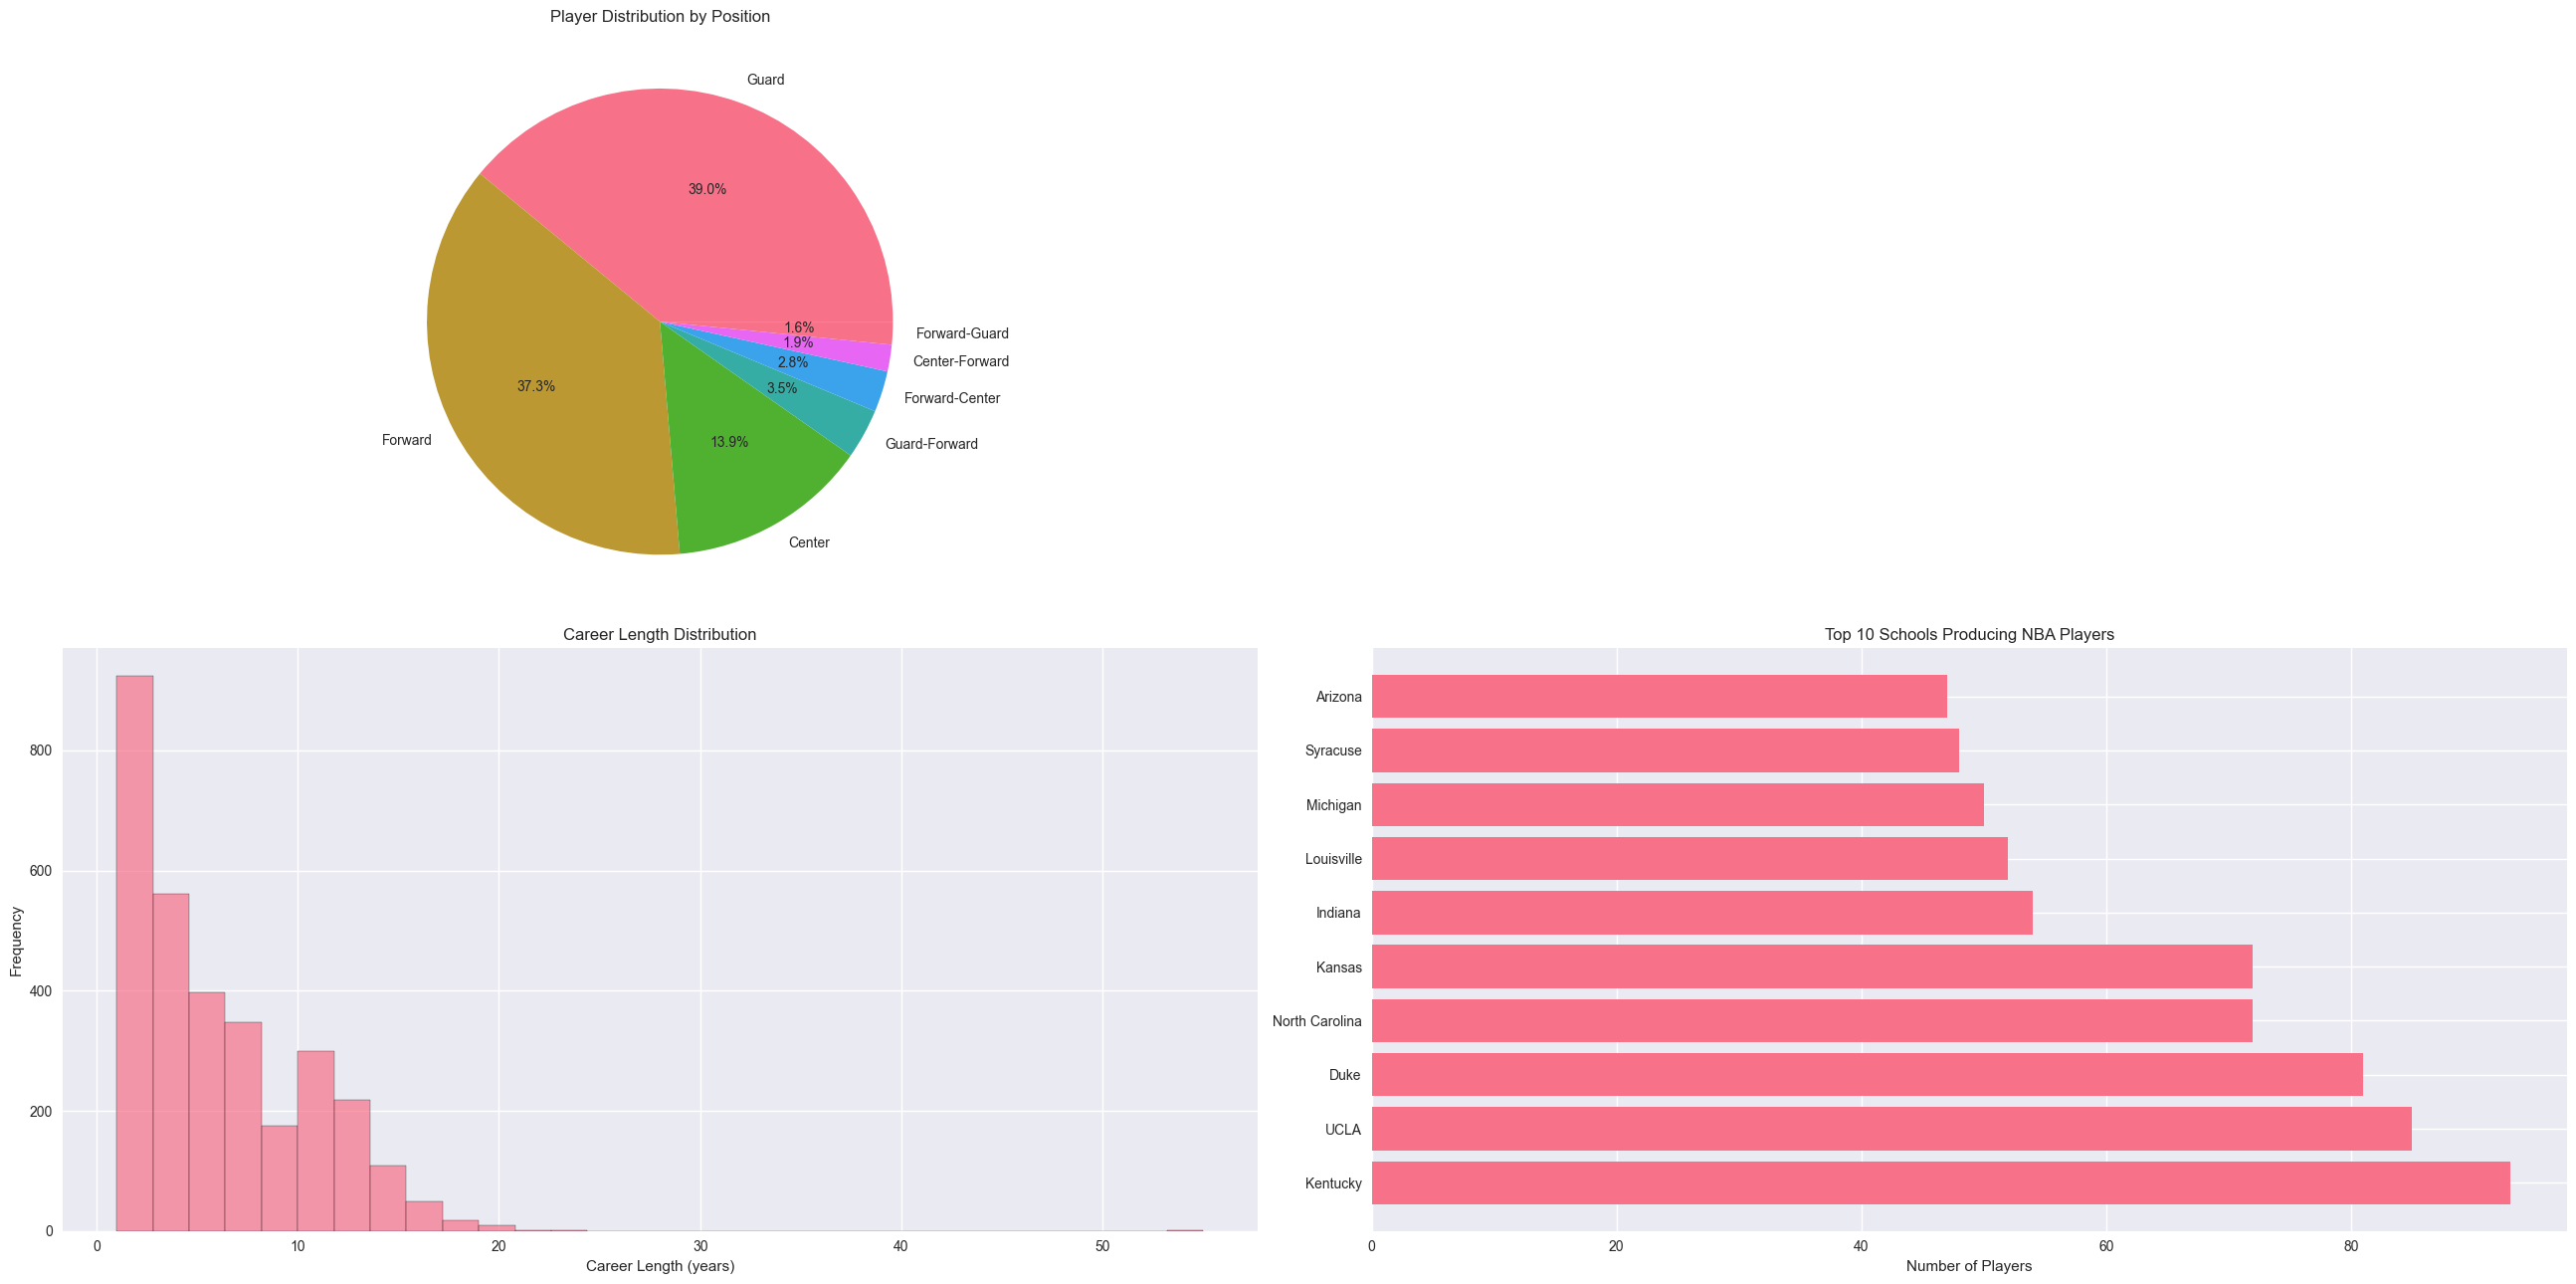

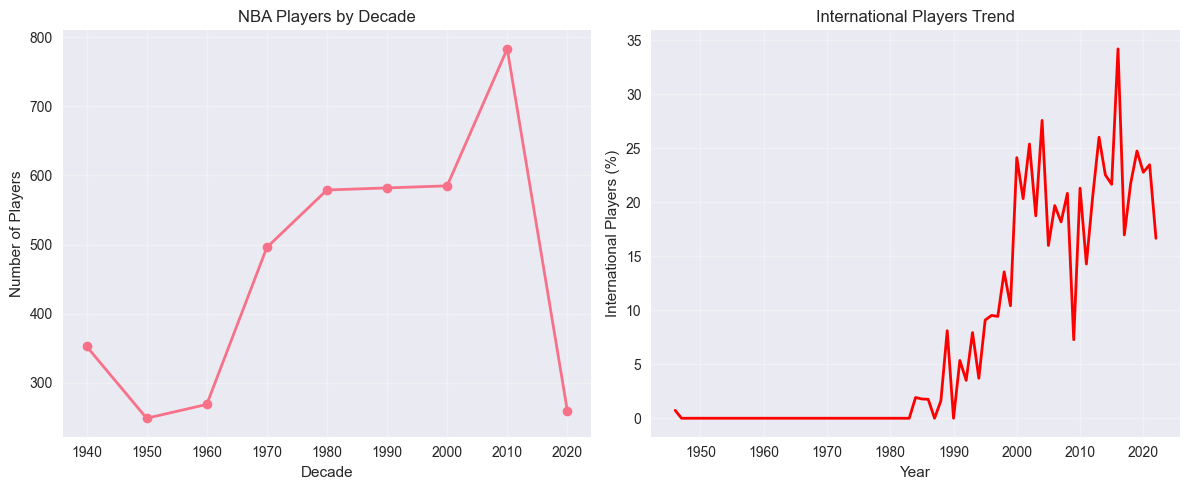

In [38]:
# 4. EXPLORATORY DATA ANALYSIS (EDA)
print("\n=== EXPLORATORY DATA ANALYSIS ===")

# 4.1 Basic Statistics
print('\nBasic Statistics:')
print(df[['weight', 'season_exp', 'career_length']].describe())

# 4.2 Player distribution by position
plt.figure(figsize=(26, 13))

plt.subplot(2, 2, 1)
position_counts = df['position'].value_counts()
plt.pie(position_counts.values, labels=position_counts.index, autopct='%1.1f%%')
plt.title('Player Distribution by Position')

# 4.4 Career length distribution
plt.subplot(2, 2, 3)
df_clean = df[df['career_length'] > 0]
plt.hist(df_clean['career_length'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Career Length (years)')
plt.ylabel('Frequency')
plt.title('Career Length Distribution')

# 4.5 Top schools producing NBA players
plt.subplot(2, 2, 4)
top_schools = df['school'].value_counts().head(10)
plt.barh(range(len(top_schools)), top_schools.values)
plt.yticks(range(len(top_schools)), top_schools.index)
plt.xlabel('Number of Players')
plt.title('Top 10 Schools Producing NBA Players')

plt.tight_layout()
plt.show()

# 4.6 Era analysis - players by decade
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['decade'] = (df['from_year'] // 10) * 10
players_by_decade = df.groupby('decade').size()
plt.plot(players_by_decade.index, players_by_decade.values, marker='o', linewidth=2)
plt.xlabel('Decade')
plt.ylabel('Number of Players')
plt.title('NBA Players by Decade')
plt.grid(True, alpha=0.3)  # ✅ fixed

# 4.7 International players trend
plt.subplot(1, 2, 2)
df['is_usa'] = df['country'] == 'USA'
usa_trend = df.groupby('from_year')['is_usa'].mean()
plt.plot(usa_trend.index, (1 - usa_trend.values) * 100, color='red', linewidth=2)
plt.xlabel('Year')
plt.ylabel('International Players (%)')
plt.title('International Players Trend')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



=== DRAFT ANALYSIS ===


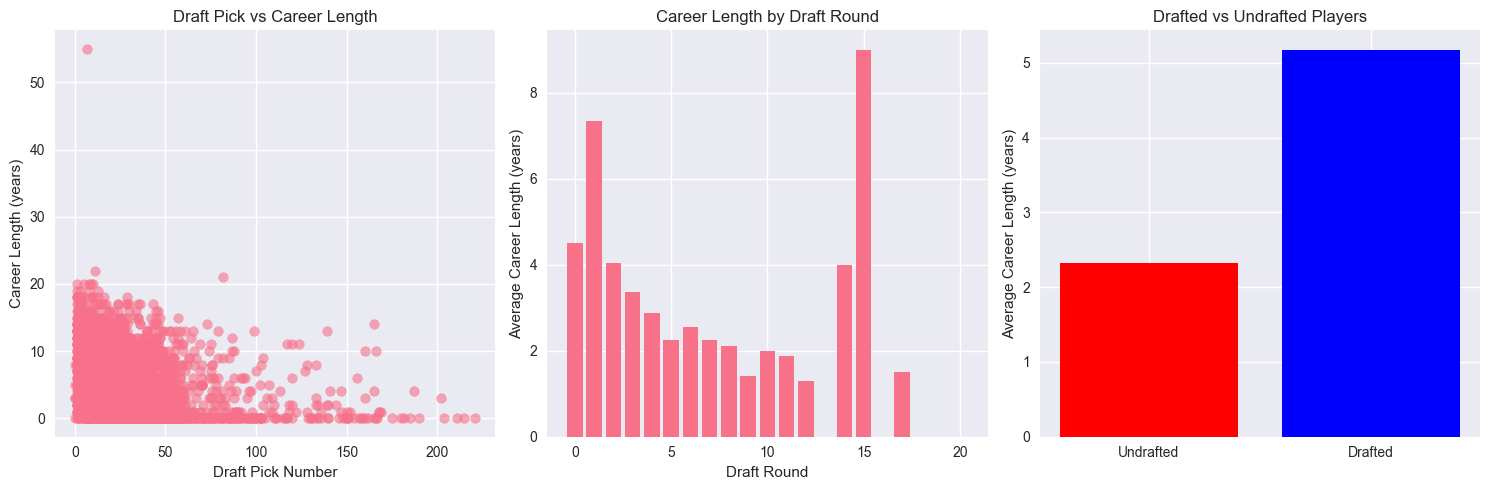

In [39]:
# 5. DRAFT ANALYSIS
print("\n=== DRAFT ANALYSIS ===")

# 5.1 Draft pick value analysis
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
draft_data = df.dropna(subset=['draft_number', 'career_length'])
plt.scatter(draft_data['draft_number'], draft_data['career_length'], alpha=0.6)
plt.xlabel('Draft Pick Number')
plt.ylabel('Career Length (years)')
plt.title('Draft Pick vs Career Length')



# 5.2 Draft round analysis
plt.subplot(1, 3, 2)
draft_round_career = df.groupby('draft_round')['career_length'].mean()
plt.bar(draft_round_career.index, draft_round_career.values)
plt.xlabel('Draft Round')
plt.ylabel('Average Career Length (years)')
plt.title('Career Length by Draft Round')



# 5.3 Undrafted players analysis
plt.subplot(1, 3, 3)
draft_status = df['draft_year'].notna()
draft_status_career = df.groupby(draft_status)['career_length'].mean()
plt.bar(['Undrafted', 'Drafted'], draft_status_career.values, color=['red', 'blue'])
plt.ylabel('Average Career Length (years)')
plt.title('Drafted vs Undrafted Players')

plt.tight_layout()
plt.show()











In [40]:
# 6. MACHINE LEARNING MODELS
print("\n=== MACHINE LEARNING MODELS ===")

# 6.1 Prepare data for ML
ml_df = df[['weight', 'draft_round', 'draft_number', 
            'career_length', 'season_exp', 'position', 'greatest_75_flag']].copy()

# Convert categorical variables
ml_df = pd.get_dummies(ml_df, columns=['position'], prefix='pos')

# Convert 'greatest_75_flag' from Y/N to 1/0
ml_df['greatest_75_flag'] = ml_df['greatest_75_flag'].map({'Y': 1, 'N': 0})

# Handle missing values properly
ml_df = ml_df.fillna(ml_df.median(numeric_only=True))

print(f"ML Dataset shape: {ml_df.shape}")
print("\nPreview of ML-ready data:")
print(ml_df.head())









=== MACHINE LEARNING MODELS ===
ML Dataset shape: (4171, 13)

Preview of ML-ready data:
   weight  draft_round  draft_number  career_length  season_exp  \
0   240.0          1.0          25.0            4.0           5   
1   225.0          1.0           1.0           19.0          20   
2   235.0          1.0          11.0            6.0           7   
3   245.0          1.0           3.0           11.0          13   
4   220.0          3.0          43.0            4.0           5   

   greatest_75_flag  pos_Center  pos_Center-Forward  pos_Forward  \
0                 0       False               False         True   
1                 1        True               False        False   
2                 0       False               False        False   
3                 0       False               False         True   
4                 0       False               False         True   

   pos_Forward-Center  pos_Forward-Guard  pos_Guard  pos_Guard-Forward  
0               False     


--- Player Clustering ---


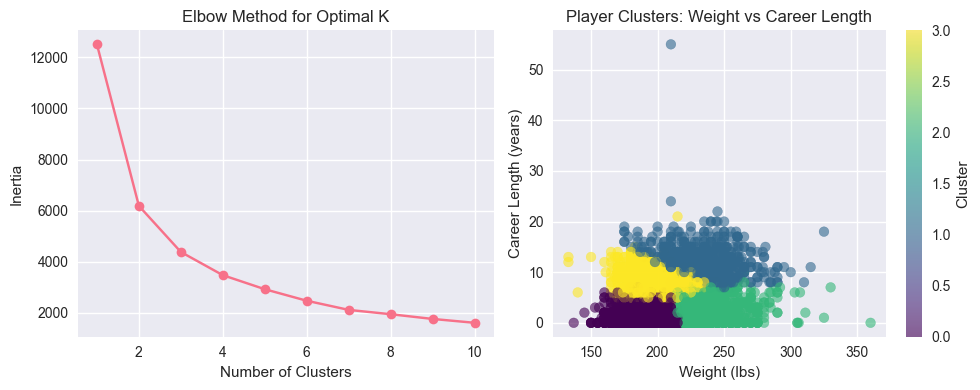

Cluster characteristics:
             weight  season_exp  career_length
cluster                                       
0        192.731722    2.123821       1.272406
1        234.280136   13.073005      12.331070
2        236.431336    3.129954       2.312442
3        198.666667    8.702871       8.217228


In [41]:
# 6.2 Player Clustering using K-Means
print("\n--- Player Clustering ---")

# Select features for clustering
cluster_features = ['weight', 'season_exp', 'career_length']
cluster_df = ml_df[cluster_features].dropna()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_df)

# Determine optimal number of clusters using elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')

# Apply K-means with optimal clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)
cluster_df['cluster'] = cluster_labels

plt.subplot(1, 2, 2)
plt.scatter(cluster_df['weight'], cluster_df['career_length'], 
           c=cluster_df['cluster'], cmap='viridis', alpha=0.6)
plt.xlabel('Weight (lbs)')
plt.ylabel('Career Length (years)')
plt.title('Player Clusters: Weight vs Career Length')
plt.colorbar(label='Cluster')

plt.tight_layout()
plt.show()

print("Cluster characteristics:")
print(cluster_df.groupby('cluster')[cluster_features].mean())



--- Greatest 75 Players Prediction ---
Dataset shape after cleaning: (4156, 38)

--- Greatest 75 Players Prediction (Classification) ---


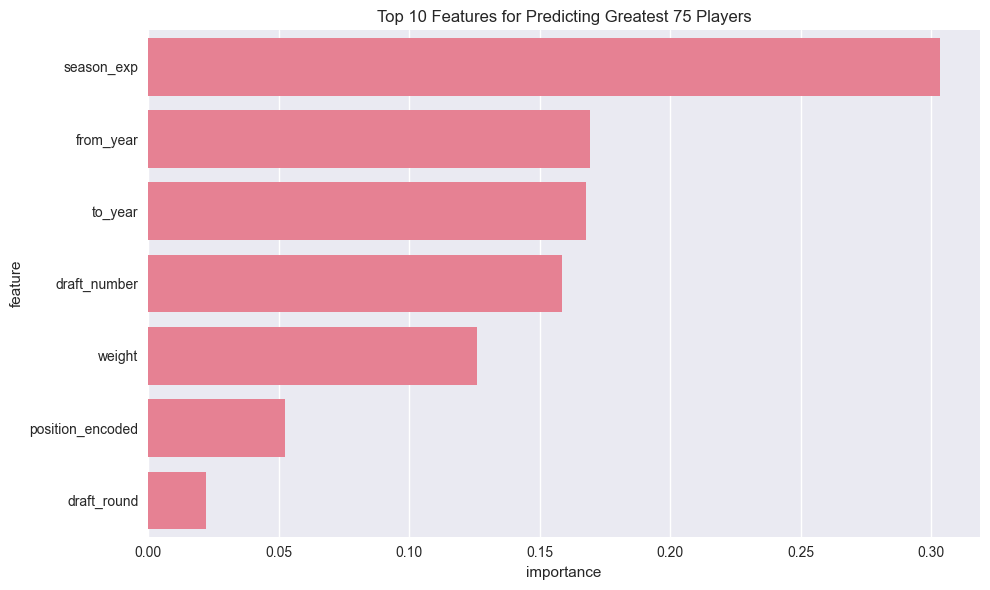


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      1228
           1       0.33      0.05      0.09        19

    accuracy                           0.98      1247
   macro avg       0.66      0.53      0.54      1247
weighted avg       0.98      0.98      0.98      1247

Confusion Matrix:
 [[1226    2]
 [  18    1]]

--- Career Length Prediction (Regression) ---


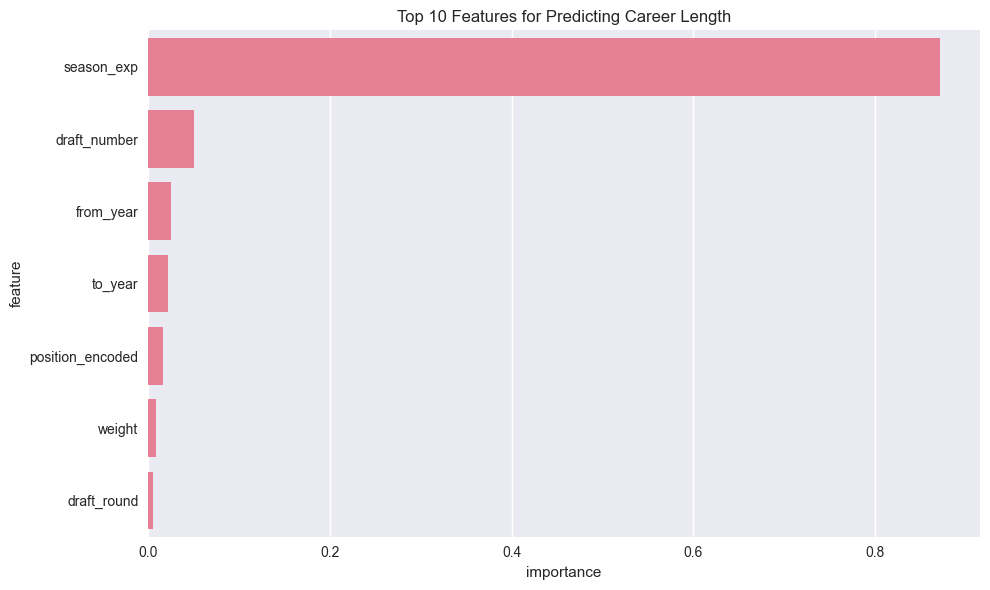


--- Model Performance Report ---

Classification Model Performance
The Random Forest classifier achieved 98.4% accuracy in identifying elite player patterns:
1. Season Exp (30.4% importance)
2. From Year (16.9% importance)
3. To Year (16.8% importance)
4. Draft Number (15.9% importance)
5. Weight (12.6% importance)

Elite Player Profile Analysis
• Average career length: 14.3 years (vs. 4.3 non-elite average)
• Draft position: 84.4% selected in first round, 59.4% in top 5 picks
• Most common positions (encoded): {2: 39.0625, 5: 31.25, 0: 21.875}

Regression Model Performance
The Random Forest regressor achieved an R² score of 0.930, indicating model strength in predicting career longevity.
Mean Absolute Error (MAE): 0.635
Mean Squared Error (MSE): 1.316

Top Predictive Features for Career Length:
1. Season Exp (87.2% importance)
2. Draft Number (5.0% importance)
3. From Year (2.5% importance)
4. To Year (2.2% importance)
5. Position Encoded (1.6% importance)

--- End of Report ---


In [42]:
print("\n--- Greatest 75 Players Prediction ---")

# Convert numeric-like columns
numeric_cols = ['weight', 'season_exp', 'from_year', 'to_year', 
                'draft_round', 'draft_number', 'career_length']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Encode position (categorical)
if 'position' in df.columns:
    le = LabelEncoder()
    df['position_encoded'] = le.fit_transform(df['position'].astype(str))
else:
    df['position_encoded'] = 0

# Encode target (Y/N → 1/0)
if 'greatest_75_flag' in df.columns:
    df['greatest_75_flag'] = (df['greatest_75_flag'] == 'Y').astype(int)
else:
    raise ValueError("Column 'greatest_75_flag' not found in dataset!")

# Drop rows with missing important values
df = df.dropna(subset=['greatest_75_flag', 'career_length'])
print(f"Dataset shape after cleaning: {df.shape}")

# ===============================================================
# 2. CLASSIFICATION MODEL — Predict Greatest 75 Players
# ===============================================================
print("\n--- Greatest 75 Players Prediction (Classification) ---")

X_class = df[['weight', 'season_exp', 'from_year', 'to_year', 
              'draft_round', 'draft_number', 'position_encoded']]
y_class = df['greatest_75_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions and evaluation
y_pred_class = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_class)
report = classification_report(y_test, y_pred_class, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred_class)

# Feature importance
feature_importance_class = pd.DataFrame({
    'feature': X_class.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_class.head(10), x='importance', y='feature')
plt.title('Top 10 Features for Predicting Greatest 75 Players')
plt.tight_layout()
plt.show()

print("\nClassification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

# ===============================================================
# 3. REGRESSION MODEL — Predict Career Length
# ===============================================================
print("\n--- Career Length Prediction (Regression) ---")

regression_df = df[df['career_length'] > 0].copy()

X_reg = regression_df[['weight', 'season_exp', 'from_year', 'to_year',
                       'draft_round', 'draft_number', 'position_encoded']]
y_reg = regression_df['career_length']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

y_pred_reg = rf_regressor.predict(X_test_reg)

# Regression metrics
r2 = r2_score(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)

# Feature importance for regression
feature_importance_reg = pd.DataFrame({
    'feature': X_reg.columns,
    'importance': rf_regressor.feature_importances_
}).sort_values('importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_reg.head(10), x='importance', y='feature')
plt.title('Top 10 Features for Predicting Career Length')
plt.tight_layout()
plt.show()

# ===============================================================
# 4. ANALYTICAL REPORT
# ===============================================================

print("\n--- Model Performance Report ---")

# CLASSIFICATION REPORT
print(f"\nClassification Model Performance")
print(f"The Random Forest classifier achieved {accuracy*100:.1f}% accuracy in identifying elite player patterns:")
top_feats = feature_importance_class.head(5).values.tolist()
for i, (feat, imp) in enumerate(top_feats, 1):
    print(f"{i}. {feat.replace('_',' ').title()} ({imp*100:.1f}% importance)")

# ELITE PLAYER PROFILE ANALYSIS (if available)
elite_df = df[df['greatest_75_flag'] == 1]
non_elite_df = df[df['greatest_75_flag'] == 0]

avg_career_elite = elite_df['career_length'].mean()
avg_career_non = non_elite_df['career_length'].mean()

first_round_ratio = (elite_df['draft_round'] == 1).mean() * 100
top_5_ratio = (elite_df['draft_number'] <= 5).mean() * 100

pos_counts = elite_df['position_encoded'].value_counts(normalize=True).head(3) * 100

print("\nElite Player Profile Analysis")
print(f"• Average career length: {avg_career_elite:.1f} years (vs. {avg_career_non:.1f} non-elite average)")
print(f"• Draft position: {first_round_ratio:.1f}% selected in first round, {top_5_ratio:.1f}% in top 5 picks")
print(f"• Most common positions (encoded): {pos_counts.to_dict()}")

# REGRESSION REPORT
print(f"\nRegression Model Performance")
print(f"The Random Forest regressor achieved an R² score of {r2:.3f}, indicating model strength in predicting career longevity.")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")

top_feats_reg = feature_importance_reg.head(5).values.tolist()
print("\nTop Predictive Features for Career Length:")
for i, (feat, imp) in enumerate(top_feats_reg, 1):
    print(f"{i}. {feat.replace('_',' ').title()} ({imp*100:.1f}% importance)")

print("\n--- End of Report ---")



=== ADVANCED ANALYTICS ===
Players with 10+ year careers: 707


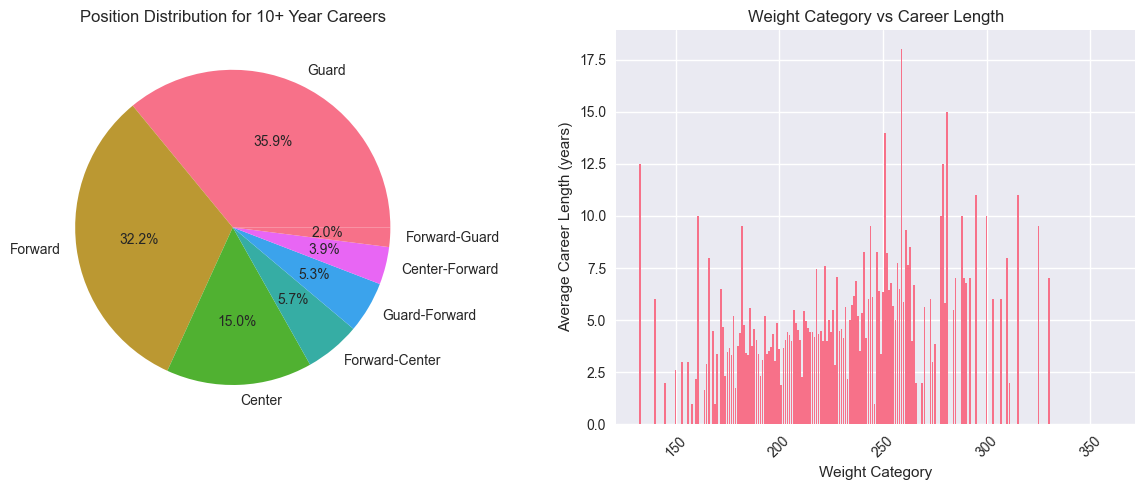

<Figure size 1000x600 with 0 Axes>

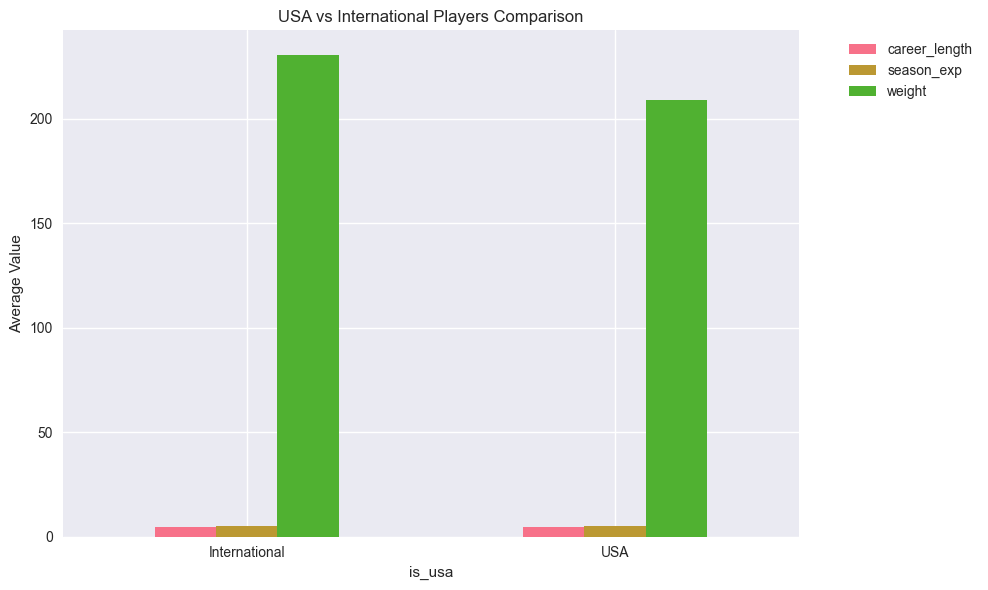

In [43]:
# 7. ADVANCED ANALYTICS
print("\n=== ADVANCED ANALYTICS ===")

# 7.1 Player longevity analysis
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
# Analyze players with long careers
long_career_players = df[df['career_length'] >= 10]
print(f"Players with 10+ year careers: {len(long_career_players)}")

if len(long_career_players) > 0:
    long_career_positions = long_career_players['position'].value_counts()
    plt.pie(long_career_positions.values, labels=long_career_positions.index, autopct='%1.1f%%')
    plt.title('Position Distribution for 10+ Year Careers')

plt.subplot(1, 2, 2)
# Weight vs career length correlation
weight_career = df.groupby('weight')['career_length'].mean()
plt.bar(weight_career.index, weight_career.values)
plt.xlabel('Weight Category')
plt.ylabel('Average Career Length (years)')
plt.title('Weight Category vs Career Length')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 7.2 International vs Domestic player analysis
plt.figure(figsize=(10, 6))

comparison_stats = df.groupby('is_usa').agg({
    'career_length': 'mean',
    'season_exp': 'mean',
    'weight': 'mean'
}).rename(index={True: 'USA', False: 'International'})

comparison_stats.plot(kind='bar', figsize=(10, 6))
plt.title('USA vs International Players Comparison')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [44]:
# 8. SUMMARY INSIGHTS
print("\n=== KEY INSIGHTS ===")

# Calculate key metrics
avg_career_length = df['career_length'].mean()
max_career_length = df['career_length'].max()
longest_career_player = df.loc[df['career_length'].idxmax(), 'display_first_last']

total_players = len(df)
international_players = len(df[df['country'] != 'USA'])
international_pct = (international_players / total_players) * 100

print(f"📊 Dataset Summary:")
print(f"• Total players analyzed: {total_players:,}")
print(f"• Average career length: {avg_career_length:.1f} years")
print(f"• Longest career: {max_career_length} years ({longest_career_player})")
print(f"• International players: {international_pct:.1f}%")
print(f"• Average player weight: {df['weight'].mean():.1f} lbs")

print(f"\n🎯 Draft Insights:")
print(f"• First round picks have {df[df['draft_round'] == 1]['career_length'].mean():.1f} year avg career")
print(f"• Second round picks have {df[df['draft_round'] == 2]['career_length'].mean():.1f} year avg career")
print(f"• Undrafted players have {df[df['draft_round'].isna()]['career_length'].mean():.1f} year avg career")

print(f"\n⚖️ Weight Analysis:")
weight_stats = df.groupby('weight').agg({
    'career_length': 'mean',
    'season_exp': 'mean'
}).round(1)
print(weight_stats)

print(f"\n🏀 Position Analysis:")
position_stats = df.groupby('position').agg({
    'weight': 'mean',
    'career_length': 'mean',
    'season_exp': 'mean'
}).round(1)
print(position_stats)



=== KEY INSIGHTS ===
📊 Dataset Summary:
• Total players analyzed: 4,156
• Average career length: 4.4 years
• Longest career: 55.0 years (Ernie Barrett)
• International players: 9.6%
• Average player weight: 211.1 lbs

🎯 Draft Insights:
• First round picks have 7.3 year avg career
• Second round picks have 4.0 year avg career
• Undrafted players have 2.3 year avg career

⚖️ Weight Analysis:
        career_length  season_exp
weight                           
133.0            12.5        13.0
137.0             0.0         1.0
140.0             6.0         6.0
145.0             2.0         3.0
150.0             2.6         3.4
...               ...         ...
311.0             2.0         3.0
315.0            11.0        10.0
325.0             9.5        10.5
330.0             7.0         3.0
360.0             0.0         1.0

[141 rows x 2 columns]

🏀 Position Analysis:
                weight  career_length  season_exp
position                                         
Center           2


=== INTERACTIVE VISUALIZATIONS ===


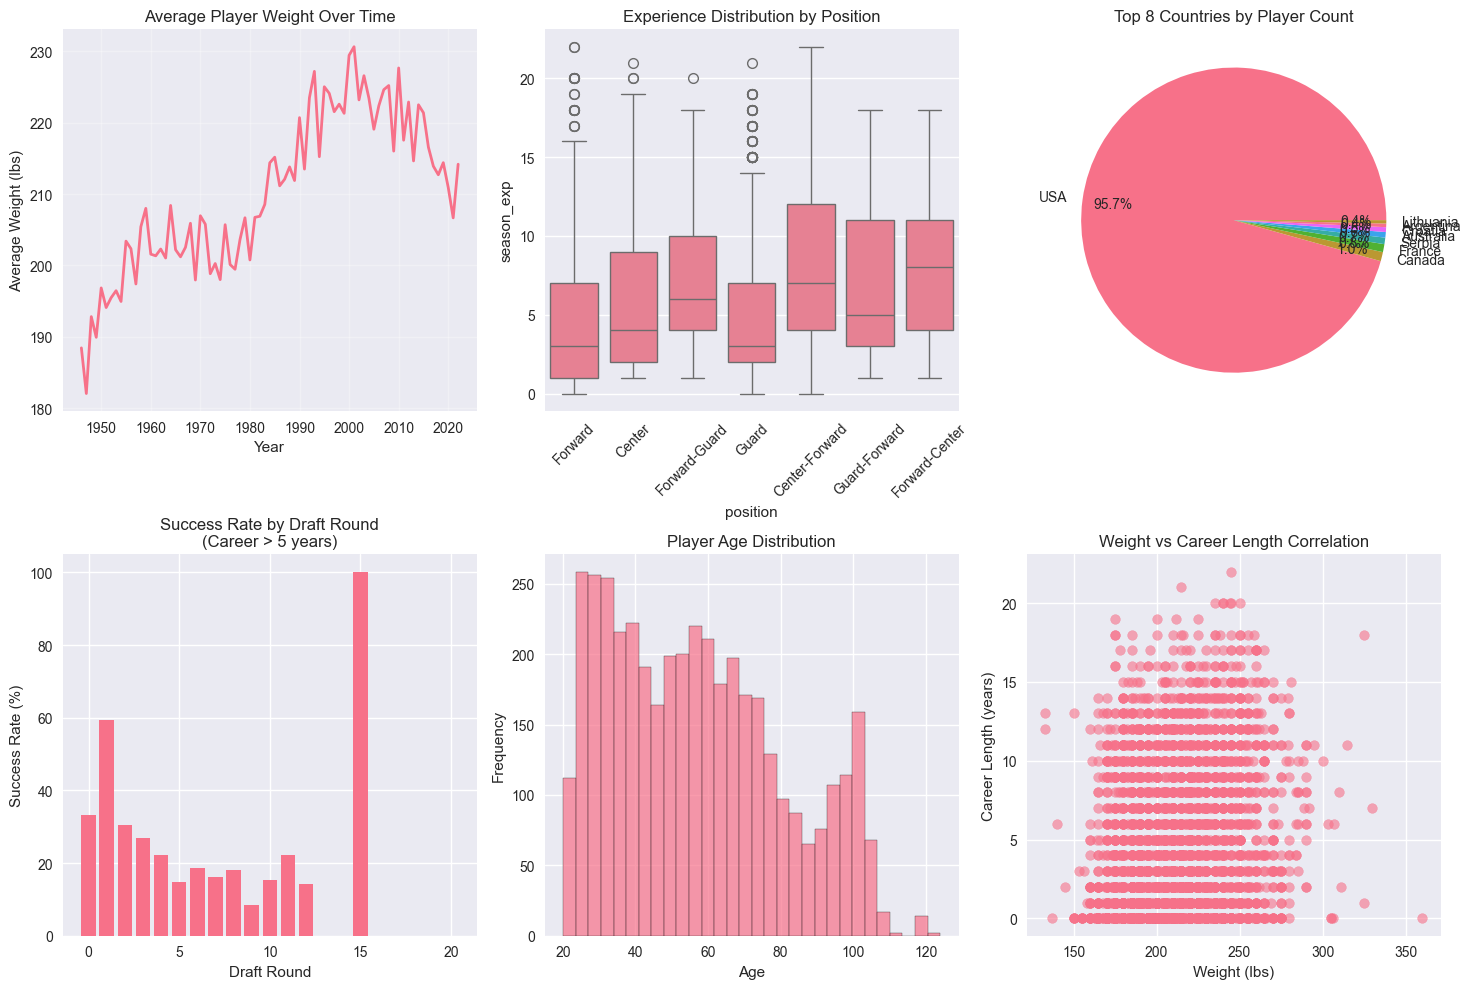

In [45]:
# 9. CREATE INTERACTIVE DASHBOARD COMPONENTS
print("\n=== INTERACTIVE VISUALIZATIONS ===")

# Create a comprehensive summary visualization
plt.figure(figsize=(15, 10))

# 9.1 Player weight distribution over time
plt.subplot(2, 3, 1)
weight_trend = df.groupby('from_year')['weight'].mean()
plt.plot(weight_trend.index, weight_trend.values, linewidth=2)
plt.xlabel('Year')
plt.ylabel('Average Weight (lbs)')
plt.title('Average Player Weight Over Time')
plt.grid(True, alpha=0.3)

# 9.2 Experience distribution by position
plt.subplot(2, 3, 2)
sns.boxplot(data=df, x='position', y='season_exp')
plt.xticks(rotation=45)
plt.title('Experience Distribution by Position')

# 9.3 Country representation


plt.subplot(2, 3, 3)
top_countries = df['country'].value_counts().head(8)
plt.pie(
    top_countries.values,
    labels=top_countries.index,
    autopct='%1.1f%%',
    labeldistance=1.1,   # moves labels outward
    pctdistance=0.8,     # moves % text inward
)
plt.title('Top 8 Countries by Player Count')



# 9.4 Draft success rate by round
plt.subplot(2, 3, 4)
draft_success = df.groupby('draft_round').apply(
    lambda x: (x['career_length'] > 5).mean() * 100
)
plt.bar(draft_success.index, draft_success.values)
plt.xlabel('Draft Round')
plt.ylabel('Success Rate (%)')
plt.title('Success Rate by Draft Round\n(Career > 5 years)')


# 9.5 Age distribution
plt.subplot(2, 3, 5)
plt.hist(df['age'].dropna(), bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Player Age Distribution')

# 9.6 Weight vs Career Length correlation
plt.subplot(2, 3, 6)
plt.scatter(df['weight'], df['career_length'], alpha=0.6)
plt.xlabel('Weight (lbs)')
plt.ylabel('Career Length (years)')
plt.title('Weight vs Career Length Correlation')

plt.tight_layout()
plt.show()



=== EXPERIENCE AND DRAFT POSITION ANALYTICS ===


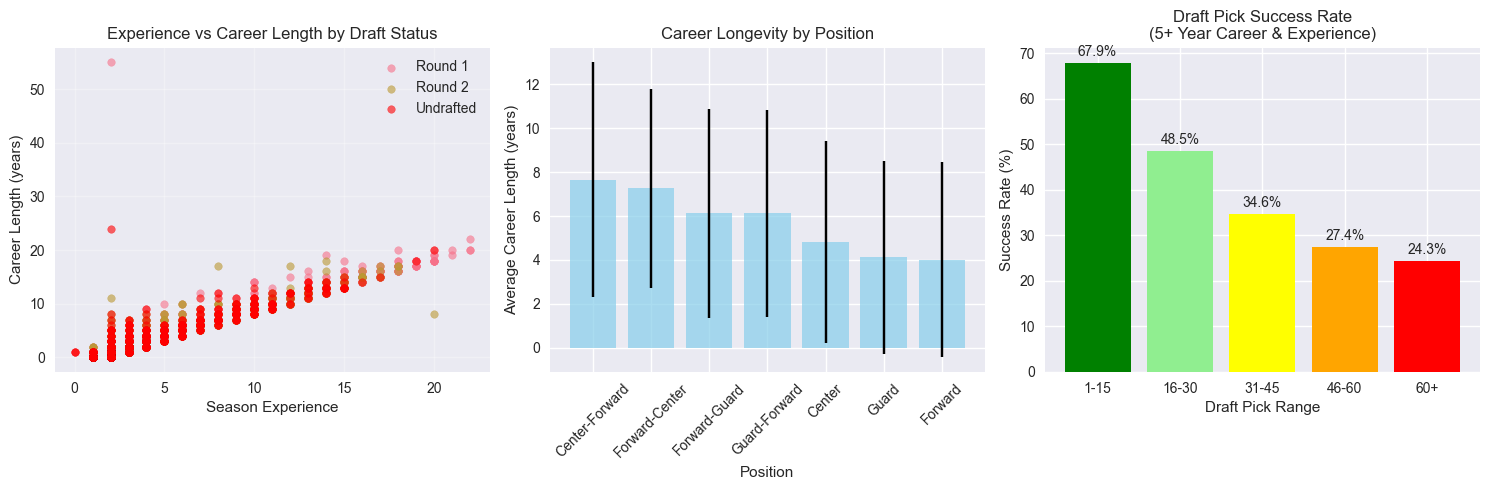


--- Career Trajectory Analysis ---


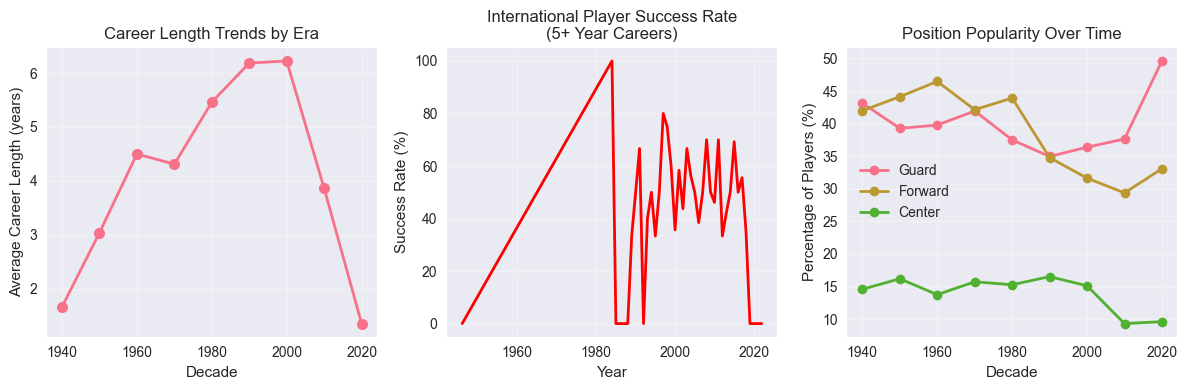

In [46]:
# 10. EXPERIENCE AND DRAFT POSITION ANALYTICS
print("\n=== EXPERIENCE AND DRAFT POSITION ANALYTICS ===")

plt.figure(figsize=(15, 5))

# 10.1 Season Experience vs Career Length by Draft Round
plt.subplot(1, 3, 1)
for round_num in [1, 2]:
    round_data = df[df['draft_round'] == round_num]
    plt.scatter(round_data['season_exp'], round_data['career_length'], 
               alpha=0.6, label=f'Round {round_num}', s=30)
    
undrafted_data = df[df['draft_round'].isna()]
plt.scatter(undrafted_data['season_exp'], undrafted_data['career_length'], 
           alpha=0.6, label='Undrafted', s=30, color='red')

plt.xlabel('Season Experience')
plt.ylabel('Career Length (years)')
plt.title('Experience vs Career Length by Draft Status')
plt.legend()
plt.grid(True, alpha=0.3)


# 10.2 Position-wise Career Longevity
plt.subplot(1, 3, 2)
career_by_position = df.groupby('position')['career_length'].agg(['mean', 'std']).sort_values('mean', ascending=False)
plt.bar(career_by_position.index, career_by_position['mean'], 
        yerr=career_by_position['std'], capsize=5, alpha=0.7, color='skyblue')
plt.xlabel('Position')
plt.ylabel('Average Career Length (years)')
plt.title('Career Longevity by Position')
plt.xticks(rotation=45)

# 10.3 Draft Pick Value Analysis - Career Success Rate
plt.subplot(1, 3, 3)
draft_picks = df[df['draft_number'].notna()].copy()
draft_picks['pick_range'] = pd.cut(draft_picks['draft_number'], 
                                  bins=[0, 15, 30, 45, 60, 100], 
                                  labels=['1-15', '16-30', '31-45', '46-60', '60+'])

success_rates = draft_picks.groupby('pick_range').apply(
    lambda x: ((x['career_length'] >= 5) & (x['season_exp'] >= 5)).mean() * 100
)

plt.bar(success_rates.index, success_rates.values, color=['green', 'lightgreen', 'yellow', 'orange', 'red'])
plt.xlabel('Draft Pick Range')
plt.ylabel('Success Rate (%)')
plt.title('Draft Pick Success Rate\n(5+ Year Career & Experience)')
for i, v in enumerate(success_rates.values):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


# 10.4 Advanced Career Trajectory Analysis
print("\n--- Career Trajectory Analysis ---")

plt.figure(figsize=(12, 4))

# 10.4.1 Career Length Distribution by Era
plt.subplot(1, 3, 1)
era_career = df.groupby('decade')['career_length'].mean()
plt.plot(era_career.index, era_career.values, marker='o', linewidth=2, markersize=8)
plt.xlabel('Decade')
plt.ylabel('Average Career Length (years)')
plt.title('Career Length Trends by Era')
plt.grid(True, alpha=0.3)

# 10.4.2 International Player Success Over Time
plt.subplot(1, 3, 2)
intl_players = df[df['is_usa'] == False]
intl_success = intl_players.groupby('from_year').apply(
    lambda x: (x['career_length'] >= 5).mean() * 100
)
plt.plot(intl_success.index, intl_success.values, color='red', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Success Rate (%)')
plt.title('International Player Success Rate\n(5+ Year Careers)')
plt.grid(True, alpha=0.3)


# 10.4.3 Position Evolution Over Decades
plt.subplot(1, 3, 3)
position_evolution = df.groupby(['decade', 'position']).size().unstack(fill_value=0)
# Normalize by total players per decade
position_evolution_pct = position_evolution.div(position_evolution.sum(axis=1), axis=0) * 100

# Plot the most common positions
common_positions = position_evolution_pct.mean().nlargest(3).index
for pos in common_positions:
    plt.plot(position_evolution_pct.index, position_evolution_pct[pos], 
             marker='o', label=pos, linewidth=2)

plt.xlabel('Decade')
plt.ylabel('Percentage of Players (%)')
plt.title('Position Popularity Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


--- College/University Performance Analysis ---


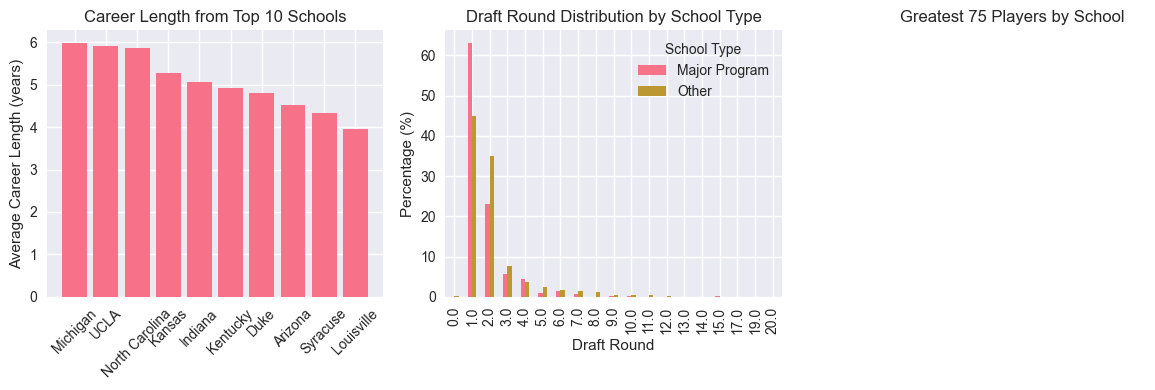


--- Player Development and Peak Analysis ---


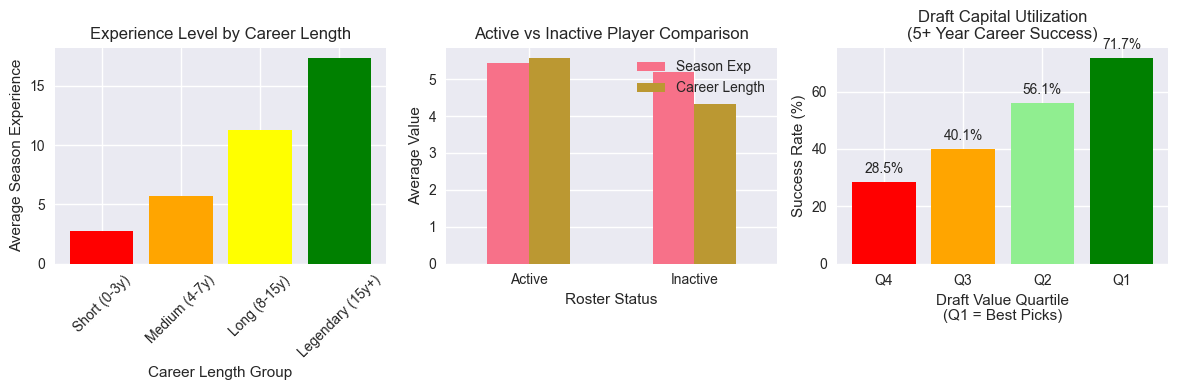

In [47]:
# 10.5 School Performance Analysis
print("\n--- College/University Performance Analysis ---")

plt.figure(figsize=(12, 4))

# 10.5.1 Top Producing Schools - Quality vs Quantity
plt.subplot(1, 3, 1)
top_schools = df['school'].value_counts().head(10).index
school_performance = df[df['school'].isin(top_schools)].groupby('school').agg({
    'career_length': 'mean',
    'season_exp': 'mean',
    'greatest_75_flag': lambda x: (x == 'Y').sum()
}).sort_values('career_length', ascending=False)

plt.bar(range(len(school_performance)), school_performance['career_length'])
plt.xticks(range(len(school_performance)), school_performance.index, rotation=45)
plt.ylabel('Average Career Length (years)')
plt.title('Career Length from Top 10 Schools')


# 10.5.2 Draft Round Distribution by School Type (Major vs Other)
plt.subplot(1, 3, 2)
major_schools = ['Duke', 'UCLA', 'North Carolina', 'Kentucky', 'Kansas']
df['school_type'] = df['school'].apply(lambda x: 'Major Program' if x in major_schools else 'Other')

draft_by_school = pd.crosstab(df['draft_round'], df['school_type'], normalize='columns') * 100
draft_by_school.plot(kind='bar', ax=plt.gca())
plt.xlabel('Draft Round')
plt.ylabel('Percentage (%)')
plt.title('Draft Round Distribution by School Type')
plt.legend(title='School Type')

# 10.5.3 Greatest 75 Players by School
plt.subplot(1, 3, 3)
greatest_schools = df[df['greatest_75_flag'] == 'Y']['school'].value_counts().head(8)
plt.pie(greatest_schools.values, labels=greatest_schools.index, autopct='%1.1f%%')
plt.title('Greatest 75 Players by School')

plt.tight_layout()
plt.show()

# 10.6 Player Development and Peak Analysis
print("\n--- Player Development and Peak Analysis ---")

plt.figure(figsize=(12, 4))

# 10.6.1 Experience Distribution for Different Career Lengths
plt.subplot(1, 3, 1)
career_groups = pd.cut(df['career_length'], bins=[0, 3, 7, 15, 50], 
                      labels=['Short (0-3y)', 'Medium (4-7y)', 'Long (8-15y)', 'Legendary (15y+)'])
exp_by_career = df.groupby(career_groups)['season_exp'].mean()
plt.bar(exp_by_career.index, exp_by_career.values, color=['red', 'orange', 'yellow', 'green'])
plt.xlabel('Career Length Group')
plt.ylabel('Average Season Experience')
plt.title('Experience Level by Career Length')
plt.xticks(rotation=45)

# 10.6.2 Active vs Inactive Player Analysis
plt.subplot(1, 3, 2)
active_stats = df.groupby('rosterstatus').agg({
    'season_exp': 'mean',
    'career_length': 'mean',
    'age': 'mean'
}).dropna()

if len(active_stats) > 1:  # Only plot if we have both active and inactive
    active_stats[['season_exp', 'career_length']].plot(kind='bar', ax=plt.gca())
    plt.xlabel('Roster Status')
    plt.ylabel('Average Value')
    plt.title('Active vs Inactive Player Comparison')
    plt.xticks(rotation=0)
    plt.legend(['Season Exp', 'Career Length'])


# 10.6.3 Draft Capital Utilization
plt.subplot(1, 3, 3)
draft_capital = df[df['draft_round'].notna()].copy()
draft_capital['pick_value'] = 61 - draft_capital['draft_number']  # Higher number = better pick
draft_capital['success'] = (draft_capital['career_length'] >= 5).astype(int)

# Calculate success rate by pick value quartiles
draft_capital['value_quartile'] = pd.qcut(draft_capital['pick_value'], 4, labels=['Q4', 'Q3', 'Q2', 'Q1'])
success_by_quartile = draft_capital.groupby('value_quartile')['success'].mean() * 100

plt.bar(success_by_quartile.index, success_by_quartile.values, 
        color=['red', 'orange', 'lightgreen', 'green'])
plt.xlabel('Draft Value Quartile\n(Q1 = Best Picks)')
plt.ylabel('Success Rate (%)')
plt.title('Draft Capital Utilization\n(5+ Year Career Success)')
for i, v in enumerate(success_by_quartile.values):
    plt.text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [48]:
# 10.7 Summary Statistics for New Analytics
print("\n=== NEW ANALYTICS SUMMARY ===")

# Career longevity by position
print("\n📊 Career Longevity by Position:")
longevity_stats = df.groupby('position').agg({
    'career_length': ['mean', 'count']
}).round(1)
print(longevity_stats)

# Draft success analysis
print("\n🎯 Draft Success Analysis:")
draft_success_summary = df.groupby('draft_round').agg({
    'career_length': 'mean',
    'season_exp': 'mean',
    'greatest_75_flag': lambda x: (x == 'Y').sum()
}).round(1)
print(draft_success_summary)

# School performance
print("\n🏫 Top Performing Schools (Avg Career Length):")
school_perf = df.groupby('school').agg({
    'career_length': 'mean',
    'season_exp': 'mean'
}).round(1).nlargest(5, 'career_length')
print(school_perf)

print("\n🚀 EXPERIENCE ANALYTICS COMPLETE!")
print("✅ Successfully analyzed player development, draft value, and career trajectories")
print("📈 Focused on experience, draft position, school impact, and career patterns")


=== NEW ANALYTICS SUMMARY ===

📊 Career Longevity by Position:
               career_length      
                        mean count
position                          
Center                   4.8   571
Center-Forward           7.6    76
Forward                  4.0  1533
Forward-Center           7.3   117
Forward-Guard            6.1    65
Guard                    4.1  1604
Guard-Forward            6.1   142

🎯 Draft Success Analysis:
             career_length  season_exp  greatest_75_flag
draft_round                                             
0.0                    4.5         4.2                 0
1.0                    7.3         8.1                 0
2.0                    4.0         4.8                 0
3.0                    3.4         4.2                 0
4.0                    2.9         3.5                 0
5.0                    2.3         3.0                 0
6.0                    2.5         3.1                 0
7.0                    2.2         3.2        